In [15]:
import numpy as np
import torch
import sys
sys.path.append('/home/nkamath5/miniconda3/pkgs/torch-two-sample-0.1-py36h39e3cac_0/lib/python3.6/site-packages')  
# explicitly added to path above since this package wasn't getting found during execution
import torch_two_sample as tst  # edited
import torch.distributed as dist
import torch.nn.functional as F
import os
import random
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
def public_features(features, data):
    # function copied from loss.py
    all_features = False
    if 'all' in  features:
        all_features = True
    final_features = [] # keep appending relevant features to this list & convert to tensor at the end
    data          = torch.squeeze(data).float()  # data is already expected to be in float, but leaving the .float() here
    if all_features or ('areas' in  features):
        phantom_masks = (data > -0.6471).float()  # [(45/127.5)-1] = -0.6471
        # gradients are zero at all places where a step function is differentiable, hence error signal is not passed to gen images via this route
        areas         = torch.sum(phantom_masks, dim=(1,2)) #.unsqueeze(1)
        final_features.append(areas)
    if all_features or ('fg_ratios' in  features) or ('fat_areas' in  features):
        fat           = (data >= -0.6471) * (data < -0.0588)  # [(120/127.5)-1] = -0.0588
        fat_areas     = torch.sum(fat, dim=(1,2)) #.unsqueeze(1)
        if all_features or ('fat_areas' in  features): final_features.append(fat_areas)
    if all_features or ('fg_ratios' in  features) or ('gln_areas' in  features):
        gln           = (data >= -0.0588) * (data < 0.7725)  # [(226/127.5)-1] = 0.7725
        gln_areas     = torch.sum(gln, dim=(1,2)) #.unsqueeze(1)
        if all_features or ('gln_areas' in  features): final_features.append(gln_areas)
    if all_features or ('fg_ratios' in  features):
        fg_ratios     = torch.log10(((fat_areas + 0.00012)/ (gln_areas + 0.0001)) + 1)
        final_features.append(fg_ratios)
        # 1 added since it protects from NaN values for low values inside log, without affecting gradient a lot (check graphically for clarity)
        #print("data ", data.requires_grad, " phantom_masks ", phantom_masks.requires_grad, " areas ", areas.requires_grad)
        #print("fat_areas ", fat_areas.requires_grad, " gln_areas ", gln_areas.requires_grad, " fg_ratios ", fg_ratios.requires_grad)
    N = len(data)  # alternatively N = data.shape[0], i.e. batch size
    data          = data.reshape(N, -1)
    #print("data: ", data.shape)
    if all_features or 'means' in  features or 'skewnesses' in  features or 'kurtoses' in  features or 'balances' in  features:
        means         = torch.mean(data, dim=1) #.unsqueeze(1)
        if all_features or ('means' in  features): final_features.append(means)
        #print("means: ", means.shape)
    if all_features or 'stds' in  features or 'skewnesses' in  features or 'kurtoses' in  features:
        stds          = torch.std(data, dim=1) #.unsqueeze(1)
        if all_features or ('stds' in  features): final_features.append(stds)
        #print("stds: ", stds.shape)
    if all_features or 'skewnesses' in  features:
        #print(f"means.shape: {means.shape}") # ([16])
        #print(f"data.shape: {data.shape}")  # ([16, 262144*])
        #print(f"stds.shape: {stds.shape}")  # ([16])
        #print(f"stds.unqueeze(-1) shape: {(stds.unsqueeze(-1)).shape}")
        skewnesses    = (torch.mean((data - means.unsqueeze(-1))**3, dim=1) / stds.squeeze()**3) #.unsqueeze(1)
        final_features.append(skewnesses)
    if all_features or 'kurtoses' in  features:
        kurtoses      = ((torch.mean((data - means.unsqueeze(-1))**4, dim=1) / stds.squeeze()**4) - 3.0) #.unsqueeze(1)
        final_features.append(kurtoses)
        #print(torch.quantile(data, 0.7, dim=1).shape)
    if all_features or 'balances' in  features:
        balances = (torch.quantile(data, 0.7, dim=1) - means) / (means - torch.quantile(data, 0.3, dim=1))
                    #( torch.quantile(data, 0.7, dim=1).unsqueeze(1) - means ) \
                    #/ ( means - torch.quantile(data, 0.3, dim=1).unsqueeze(1) )
        final_features.append(balances)
                
    return torch.stack(final_features, dim=1).squeeze(1)

In [17]:
def sample_images(directory, b):
    # List all PNG files in the directory
    all_files = [f for f in os.listdir(directory) if f.endswith('.png')]
    # Randomly sample 'b' files
    sampled_files = random.sample(all_files, b)
    images = [Image.open(os.path.join(directory, file)) for file in sampled_files]
    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images = [torch.tensor(np.array(image)) for image in images]
    # Stack all tensors to form a single tensor
    images = torch.stack(images)
    images = (images - 127.5) / 127.5
    return images

In [18]:
def plot_loss_violins(data, batch_sizes, save_path=None):
    """
    Plots violin plots for loss values across different batch sizes.

    :param data: A list of 1D numpy arrays. list dim is batch_size dim & array dim are the loss values for that batch_size
    :param batch_sizes: A list of batch sizes corresponding to the outer dimension of 'data'.
    :param save_path: File path to save the plot image. If None, the plot is not saved.
    """
    # Check if the batch sizes list matches the data's first dimension, else it is some transpose of the data
    if len(data) != len(batch_sizes):
        raise ValueError("Length of batch_sizes must match the first dimension of data.")

    plot_data = []
    for i, batch_size in enumerate(batch_sizes):
        for loss in data[i]:
            plot_data.append({'Batch Size': batch_size, 'Loss': loss})

    df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Batch Size', y='Loss', data=df, order=batch_sizes)

    last_slash_index = full_path.rfind('/') # # Find the position of the last '/'
    png_index = full_path.rfind('.png') # Find the position of '.png'
    dir_part = full_path[last_slash_index + 1:png_index] # Extract the part of the string between the last '/' and '.png'
    plt.title(dir_part + ' Loss Dispersion across Different Batch Sizes')

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

In [19]:
gen_directory = '/data/nkamath5/stats_aware_gans/aapm_generated_images/00030-128-auto1-gamma2-batch64-kimg002721-125K'
#'/data/nkamath5/stats_aware_gans/aapm_generated_images/00030-128-auto1-gamma2-batch64-kimg000302-125K'
#'/data/nkamath5/stats_aware_gans/aapm_generated_images/00030-128-auto1-gamma2-batch64-kimg002721-125K'
#/data/nkamath5/stats_aware_gans/aapm_generated_images/00030-128-auto1-gamma2-batch64-kimg008467-125K
real_directory = '/shared/rsaas/nkamath5/train_128'

In [20]:
b_list = [32, 128, 1024]
loss_values = [] # will be a list of lists

for batch_size in b_list:
    M = 100 if batch_size == 1024 else 500
    M = 20 if batch_size == 4096 else M
    print(f'b is {batch_size} and M is {M}')

    loss_values_for_a_batch_size = []
    for i in tqdm(range (M)):
        
        gen_img = sample_images(gen_directory, batch_size)
        real_img = sample_images(real_directory, batch_size)
        
        gen_vectors = public_features('all', gen_img)
        real_vectors = public_features('all', real_img)
        
        loss = 'FR'
        if loss is 'FR':
            use_pca_cosine_logic = True
            num_random_runs = 200
            assert num_random_runs < batch_size*batch_size #
            alphas = [0.02]
            # take features, num_random_runs (if 0 then no cosine logic), batch_size, alphas as inputs from cli
            if num_random_runs == 0:
                use_pca_cosine_logic = False

        
            if use_pca_cosine_logic == True:
                _, _, V = torch.pca_lowrank(real_vectors, center=True)
                # matmul(A, V[:, :k]) projects data to the first k principal components
                real_vectors = torch.matmul(real_vectors, V[:, :real_vectors.shape[1]]) # pca projections
                gen_vectors = torch.matmul(gen_vectors, V[:, :real_vectors.shape[1]]) # projecting onto p components of reals
                # real_vectors & gen_vectors must now be of shape (batch_size_per_gpu x k)
                
                #sample 2 random vectors from reals & find their cosine similarities
                # create a (2x batch_size) tensor; row 0 are indices for first vectors, row 1 for second in cos sim calculation
                random_matching = torch.randint(low=0, high=real_vectors.shape[0], size=(2,  num_random_runs)) # --> will not give ints without replacement!
                real_vecs_set_1 = real_vectors[random_matching[0]]  # size (num_random_runs, k)
                real_vecs_set_2 = real_vectors[random_matching[1]]
                cossim_reals = F.cosine_similarity(real_vecs_set_1, real_vecs_set_2, dim=1, eps=1e-8)

                random_matching = torch.randint(low=0, high=real_vectors.shape[0], size=(2,  num_random_runs))
                real_vecs_set_1 = real_vectors[random_matching[0]]
                gen_vecs_set_2 = gen_vectors[random_matching[1]]
                cossim_mixed = F.cosine_similarity(real_vecs_set_1, gen_vecs_set_2, dim=1, eps=1e-8)

                # cosine similarity vectors become our final real & gen vectors.
                real_vectors = cossim_reals.unsqueeze(1) # to make 1-D tensor into 2-D tensor for purposes of code in two_sample_test
                gen_vectors = cossim_mixed.unsqueeze(1)

            if use_pca_cosine_logic:
                loss_tst_fn = tst.statistics_diff.SmoothFRStatistic(num_random_runs,  num_random_runs, cuda=False, compute_t_stat=True) # since the datapoints being compared for similar distribution are now num_random_runs in number
            else:
                loss_tst_fn = tst.statistics_diff.SmoothFRStatistic(batch_size, batch_size, cuda=False, compute_t_stat=True)
            loss_tst = loss_tst_fn(real_vectors, gen_vectors, alphas =  alphas)  # https://torch-two-sample.readthedocs.io/en/latest/#torch_two_sample.statistics_diff.SmoothFRStatistic.__call__

            loss_values_for_a_batch_size.append(loss_tst)

    loss_values.append(np.array(loss_values_for_a_batch_size, dtype=float)) # list of 1D arrays

# Save as NPZ
arrays_dict = {f'loss_{b_list[i]}': array for i, array in enumerate(loss_values)}
np.savez('/home/nkamath5/stats_aware_gans/stats-aware-stylegan2-ada/scripts/loss_data_00030-128-auto1-gamma2-batch64-kimg002721-125K.npz', **arrays_dict)

b is 32 and M is 500


  0%|                                                                                                                                                                                                                                        | 0/500 [00:00<?, ?it/s]/home/nkamath5/miniconda3/pkgs/torch-two-sample-0.1-py36h39e3cac_0/lib/python3.6/site-packages/torch_two_sample/inference_trees.py:95: UserWarning: masked_select received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370156314/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:733.)
  return torch.masked_select(matrix, triu_mask)
/home/nkamath5/miniconda3/pkgs/torch-two-sample-0.1-py36h39e3cac_0/lib/python3.6/site-packages/torch_two_sample/inference_trees.py:79: UserWarning: masked_scatter_ received a mask with dtype torch.uint8, this behavior is now deprecated,please use a mask with dtype torch.bool inst

b is 128 and M is 500


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:11:49<00:00,  8.62s/it]


b is 1024 and M is 100


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [20:44<00:00, 12.45s/it]


NameError: name 'full_path' is not defined

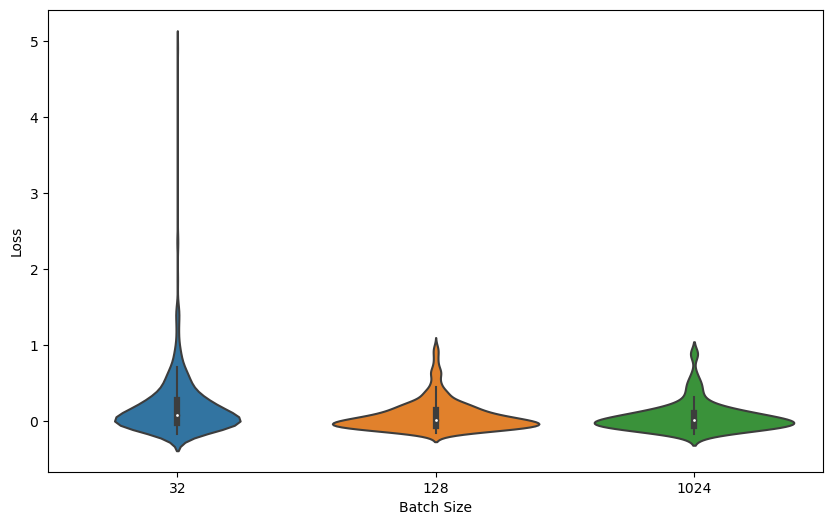

In [21]:
plot_loss_violins(loss_values, b_list) # 00030-128-auto1-gamma2-batch64-kimg002721-125K

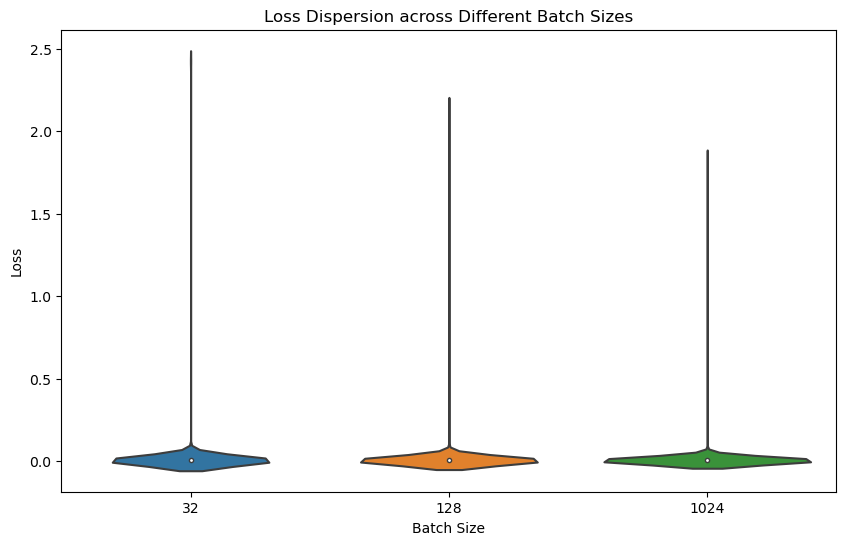

In [10]:
plot_loss_violins(loss_values, b_list) # 00030-128-auto1-gamma2-batch64-kimg000302-125K